<a href="https://colab.research.google.com/github/soutrik71/MInMaxBERT/blob/main/notebook/RobertaClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will do the following processes:
1. Train a question classifier using Roberta Basic and Advanced
2. Use of Roberta tokenizer
3. Evaluate the results

In [4]:
!pip install transformers datasets torcheval --upgrade --quiet
!pip install -U sentence-transformers --quiet
!pip install portalocker
!pip install torchview
!pip install torcheval
!pip install scikit-plot
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=21011e48b8c350c3c77b4c13caf5a6f3eb614c29be2fd1a65120929daae9f828
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [8]:
# !pip list --format=freeze > requirements.txt

In [28]:
import transformers
from transformers import RobertaModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torcheval.metrics import BinaryAccuracy,BinaryF1Score,BinaryPrecision,BinaryRecall,BinaryConfusionMatrix
from tqdm import tqdm
import warnings, os, random
from torchsummary import summary
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [11]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [12]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, labels, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left', legend_font=5,
                       fig_size=(16, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    plt.figure


    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = np.array(train_loss[i]).min()

        min_val_loss = np.array(val_loss[i]).min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(min_train_loss, labels[i]))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(min_val_loss, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = np.array(train_acc[i]).max()

        max_val_acc = np.array(val_acc[i]).max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ({0:.4}): {1}".format(max_train_acc, labels[i]))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ({0:.4}): {1}".format(max_val_acc, labels[i]))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc, prop={'size': legend_font})
    plt.title('Training and Validation Accuracy')

    plt.show()

In [13]:
class EarlyStopping:

    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=True, delta=1e-5, trace_func=print , path="baseline.pt"):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model, epoch):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading from git repo

In [15]:
df1 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/classifier_data.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/maz_abiconnect_curated_question_list.csv")
df3  = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/cpna_curated_list.csv")
df4 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/finance_questions_list.csv")

In [16]:
final_df = pd.concat([df1, df2,df3], ignore_index=True)

In [17]:
final_df.head()

,Domain,Question,FinalLabel
0,logistics,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,Simple
1,logistics,what should beThe target average time in route (Depot to Depot),Simple
2,marketing_abi_connect,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,Simple
3,logistics,What Are Tools And Equipment Used In Truck Departure Process?,Simple
4,maz_commercial,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",Simple


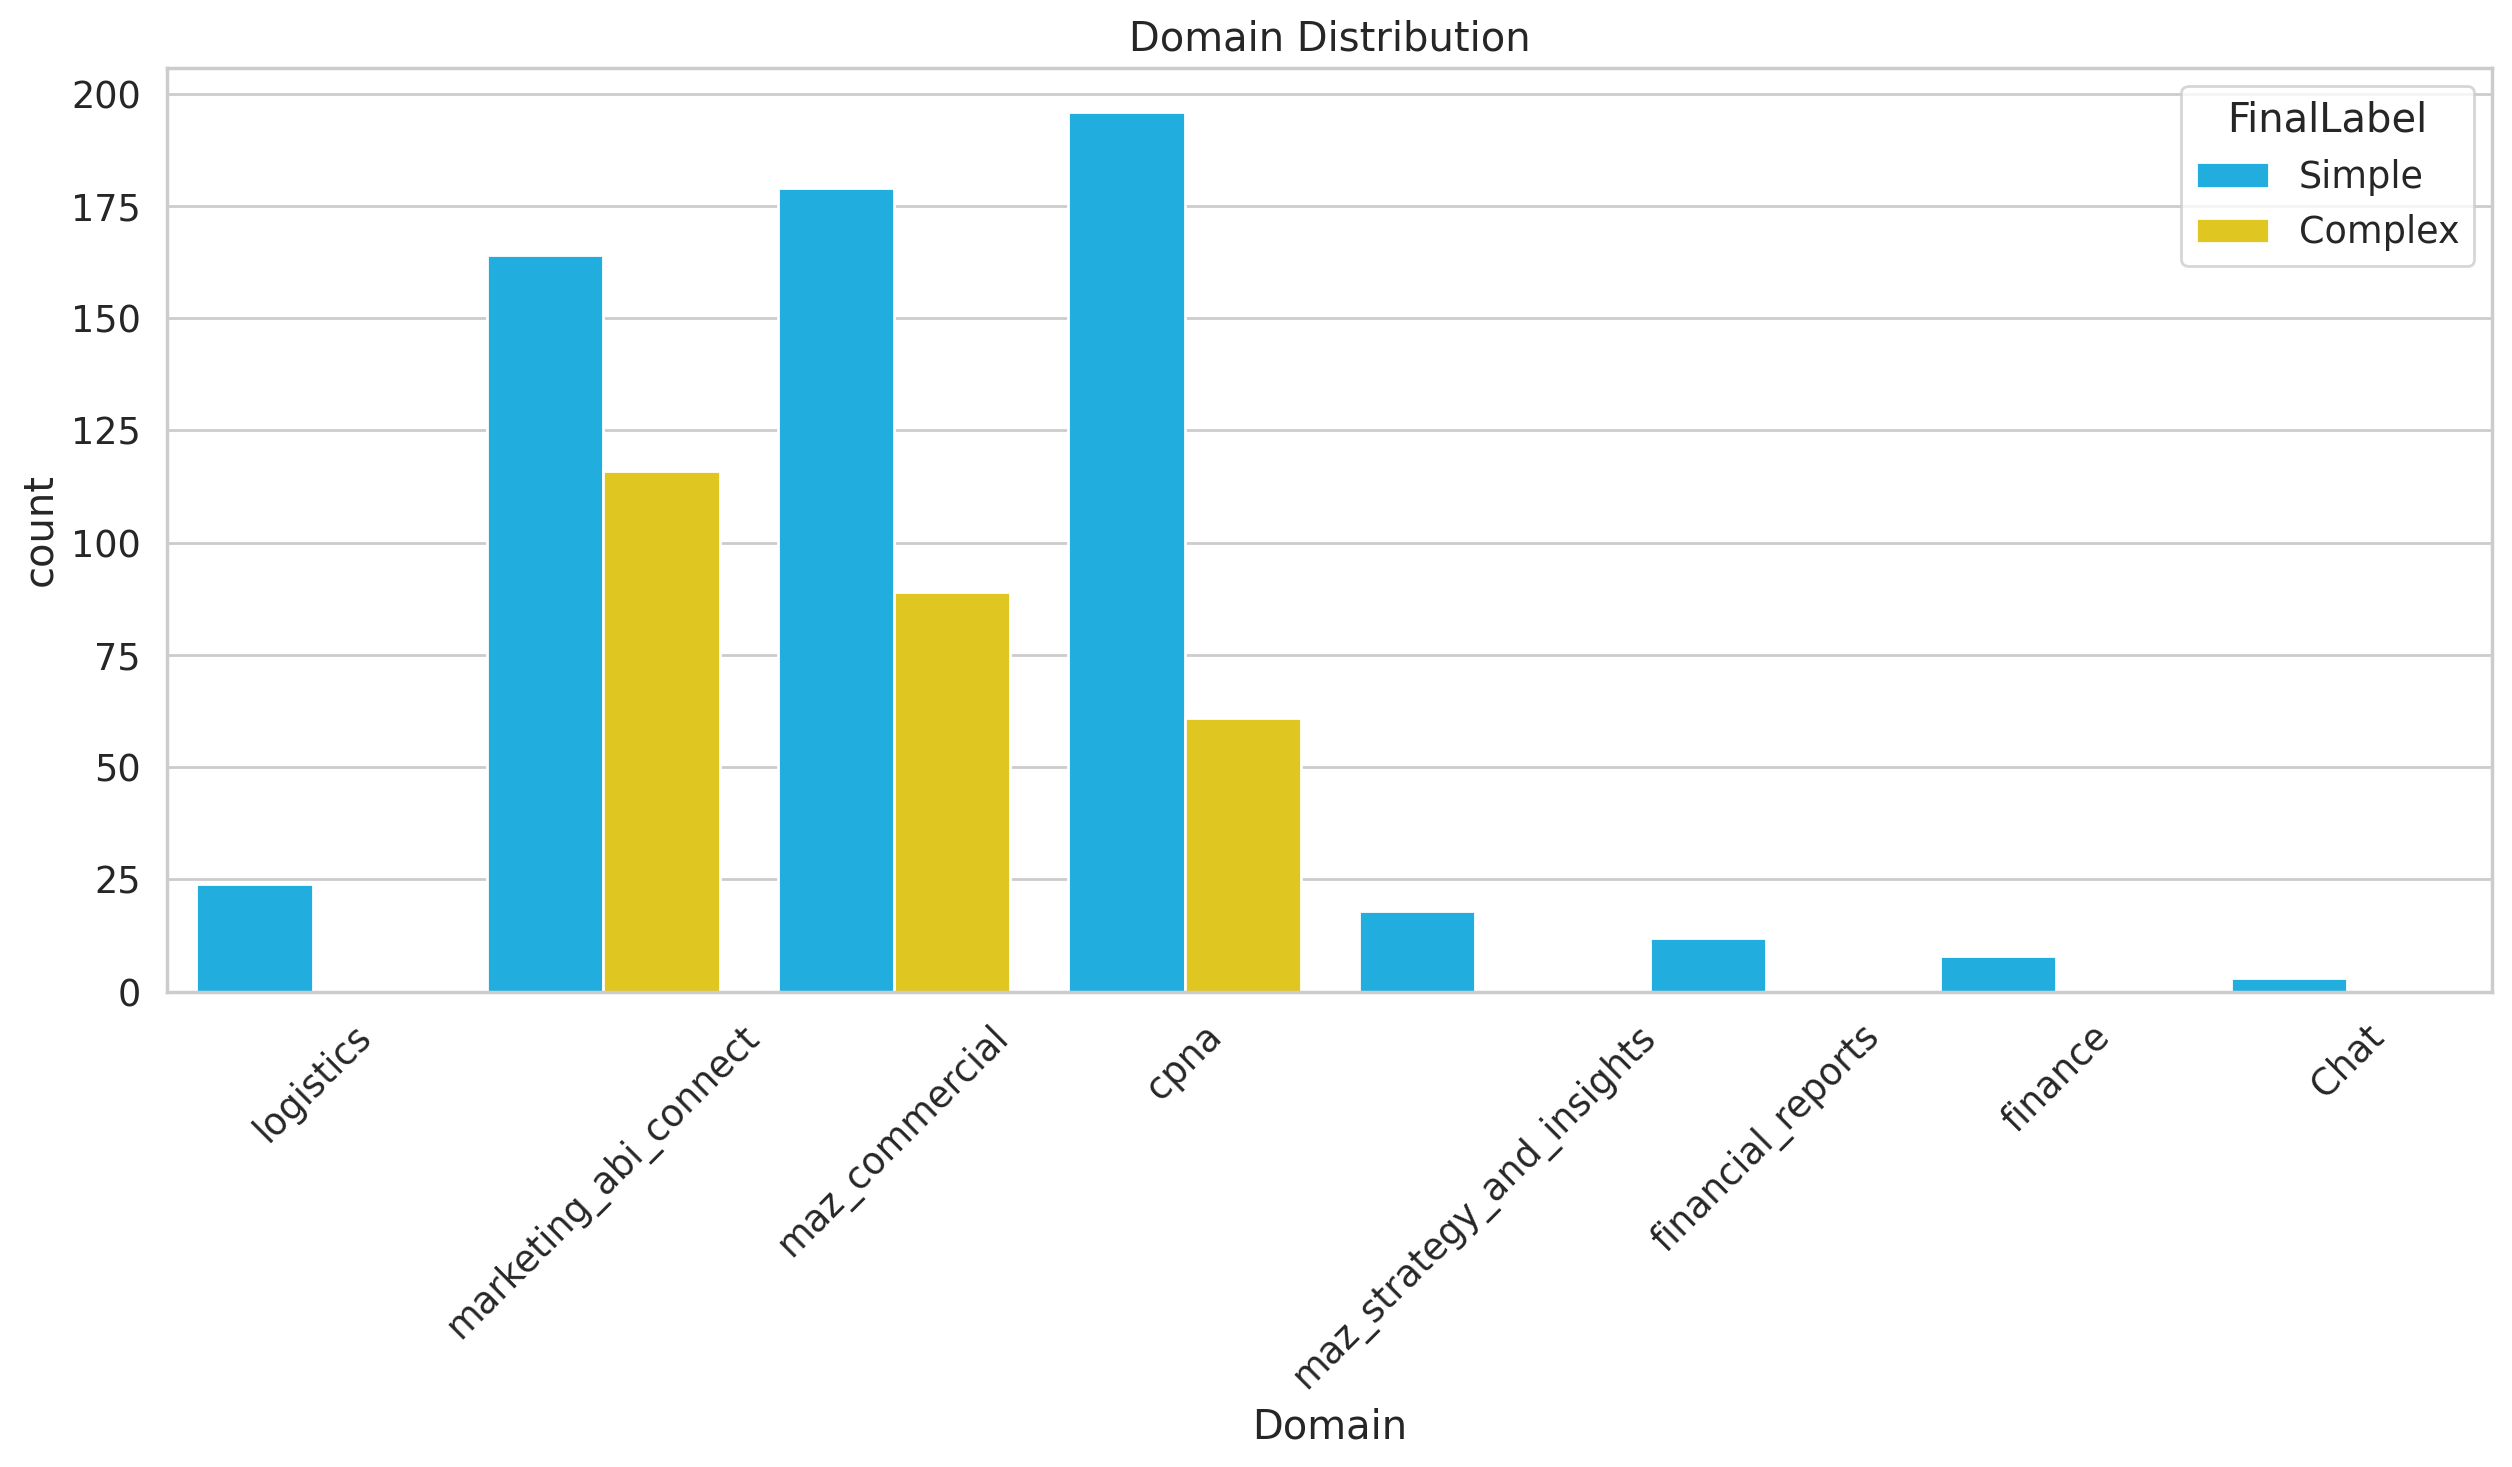

In [18]:
plt.figure(figsize=(15, 6))
sns.countplot(data=final_df, x='Domain', hue='FinalLabel')
plt.xticks(rotation=45)
plt.title('Domain Distribution')
plt.show()

In [19]:
final_df["FinalLabel"].value_counts()

Simple     604
Complex    266
Name: FinalLabel, dtype: int64

In [20]:
final_df.isnull().sum()

Domain        0
Question      0
FinalLabel    0
dtype: int64

In [21]:
final_df["FinalLabel"] = final_df["FinalLabel"].apply(lambda x: x.upper()).map({"SIMPLE":0,"COMPLEX":1})
final_df["FinalLabel"] = final_df["FinalLabel"].astype(int)

In [22]:
final_df.head()

,Domain,Question,FinalLabel
0,logistics,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,0
1,logistics,what should beThe target average time in route (Depot to Depot),0
2,marketing_abi_connect,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,0
3,logistics,What Are Tools And Equipment Used In Truck Departure Process?,0
4,maz_commercial,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",0


In [23]:
# from matplotlib import pyplot as plt
# import seaborn as sns
# final_df.groupby('Domain').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
# plt.gca().spines[['top', 'right',]].set_visible(False)

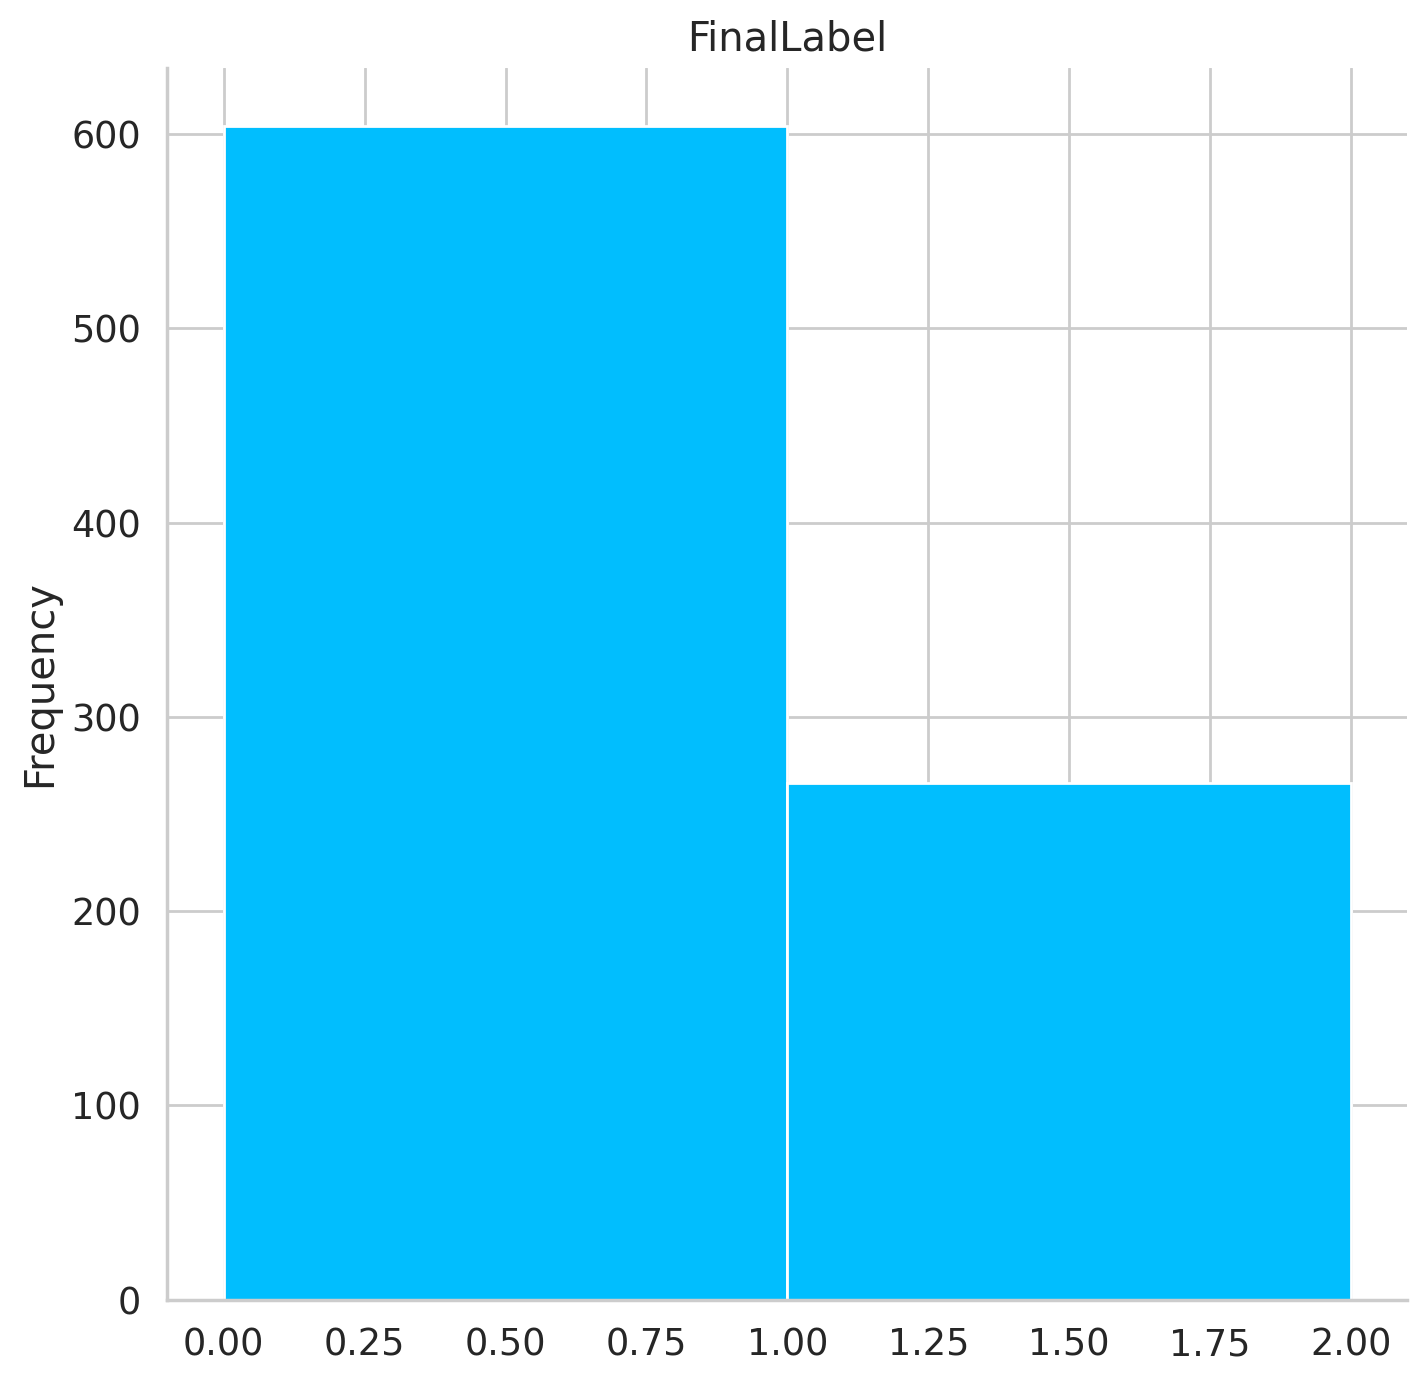

In [24]:
final_df['FinalLabel'].plot(kind='hist', bins=[0,1,2], title='FinalLabel')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [25]:
final_df.info(),"Null values",final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Domain      870 non-null    object
 1   Question    870 non-null    object
 2   FinalLabel  870 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.5+ KB


(None,
 'Null values',
 Domain        0
 Question      0
 FinalLabel    0
 dtype: int64)

In [26]:
class_names = ['Simple', 'Complex']

In [27]:
final_df['FinalLabel'].value_counts()

0    604
1    266
Name: FinalLabel, dtype: int64

## Data Preprocessing using Roberta tokenizer

In [39]:
PRE_TRAINED_MODEL_NAME = 'roberta-base' # cased means What is considered different to what ie case sensitive
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 15
learning_rate = 2e-05

In [40]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=False, force_download=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [41]:
# sample_text = final_df["Question"].values[0]
# print(sample_text)

# encoding = tokenizer.encode_plus(
#   sample_text,
#   add_special_tokens=True, # Add '[CLS]' and '[SEP]'
#   max_length=MAX_LEN,
#   pad_to_max_length = True,
#   return_attention_mask=True,
#   truncation=True, # in case larger
#   return_tensors='pt',  # Return PyTorch tensors
# )

# print(encoding.keys())

What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?
dict_keys(['input_ids', 'attention_mask'])


In [46]:
class QuestionClassficationDataset(Dataset):

  def __init__(self, question, targets, tokenizer, max_len):
    self.question = question
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.question)

  def __getitem__(self, item):
    review = str(self.question[item])
    if self.targets is not None:
      target = self.targets[item]

    # token encoder
    encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True, # Add '[CLS]' and '[SEP]'
        max_length=MAX_LEN,
        pad_to_max_length = True,
        return_attention_mask=True,
        truncation=True, # in case larger
        return_tensors='pt',  # Return PyTorch tensors
      )

    if self.targets is not None:
      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'targets': torch.tensor(target, dtype=torch.float)
      }

    else:

      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'],
      }



In [47]:
sample_dataset = QuestionClassficationDataset(
  question=[final_df["Question"].values[0]],
  targets=[final_df["FinalLabel"].values[0]],
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [48]:
for ds in sample_dataset:
  print(ds.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [49]:
next(iter(sample_dataset))

{'review_text': 'What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?',
 'input_ids': tensor([   0, 2264,   16,    5, 3164,  464,   11, 3149,   13,  276, 1518,   30,
          430, 3806,   11,  830,  291, 1922,   25, 1118,  986,  353,  116,    2,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1,    1, 

In [50]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle):
  dataset = QuestionClassficationDataset(
    question=df["Question"].values,
    targets=df["FinalLabel"].values,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle
  )

In [51]:
# startified train test split
train_df , test_df = train_test_split(final_df, test_size=0.25, random_state=42, stratify=final_df["FinalLabel"])
print(train_df.shape)
print(test_df.shape)

(652, 3)
(218, 3)


In [52]:
print(train_df["FinalLabel"].value_counts()/len(train_df))
print(test_df["FinalLabel"].value_counts()/len(test_df))

0    0.694785
1    0.305215
Name: FinalLabel, dtype: float64
0    0.692661
1    0.307339
Name: FinalLabel, dtype: float64


In [53]:
# train test dataloader
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, True)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE, False)

In [54]:
# batched of 8 with 128 token size
for sample_data in train_loader:
  print(sample_data.keys())
  print(sample_data["input_ids"].shape)
  print(sample_data["attention_mask"].shape)
  print(sample_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




## Model Building using Roberta Base

In [56]:
roberta_class = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, force_download=True)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
roberta_class

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [59]:
class RobBertaSentimentClassifier(nn.Module):

  def __init__(self, n_classes, dropout = 0.1):
    super(RobBertaSentimentClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME, force_download=True)
    self.drop = nn.Dropout(p=dropout)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.drop(pooled_output)
    return self.classifier(output)

In [60]:
robert_base_classifier = RobBertaSentimentClassifier(1).to(device)
robert_base_classifier

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobBertaSentimentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [61]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(robert_base_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

# early stopping
early_stopping = EarlyStopping(patience=3, verbose=True, path="baseline_bert.pt")

In [62]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 scheduler,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for _,data in enumerate(pbar):

    ids = data['input_ids'].to(device)
    mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    # print(f"The target shape is {targets.shape}")

    # model output
    outputs = model(ids, mask)
    outputs = outputs.flatten()
    # print(f"The output shape is {outputs.shape}")

    # calc loss
    loss = criterion(outputs, targets)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    # gradient clipping -- prevent gradient explosion
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # improvement steps
    optimizer.step() # optimizer step -> minima
    if scheduler is not None:
      scheduler.step() # scheduler step -> lr scheduling

    # metric calc
    metric.update(outputs,targets)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [63]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for _, data in enumerate(pbar, 0):
      ids = data['input_ids'].to(device)
      mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      # print(f"The target shape is {targets.shape}")

      # model output
      outputs = model(ids, mask)
      outputs = outputs.flatten()

      # print(f"The output shape is {outputs.shape}")

     # calc loss
      loss = criterion(outputs, targets)
      test_loss += loss.item()

      # metric calc
      metric.update(outputs, targets)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [64]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = robert_base_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = robert_base_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )

  print(f"The learing rate is {scheduler.get_last_lr()}")

  early_stopping(test_losses[-1], robert_base_classifier, epoch) # last recorded test loss to measure the improvement against the prior one
  if early_stopping.early_stop:
    print("Early stopping")
    break

Epoch 1/15
----------


Avg Train Loss: 0.48276539553501985 Avg Train Metric: 0.20013432477305576: 100%|██████████| 82/82 [00:18<00:00,  4.32it/s]
Avg Test Loss: 0.23267014703846403 Avg Test Metric: 0.8867648158754621: 100%|██████████| 28/28 [00:01<00:00, 18.83it/s]


The learing rate is [1.866666666666667e-05]
Validation loss decreased (inf --> 0.232670).  Saving model ...
Epoch 2/15
----------


Avg Train Loss: 0.26262919716082694 Avg Train Metric: 0.8738439272089702: 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]
Avg Test Loss: 0.23367716844326683 Avg Test Metric: 0.9129373048033033: 100%|██████████| 28/28 [00:01<00:00, 17.02it/s]


The learing rate is [1.7333333333333336e-05]
EarlyStopping counter: 1 out of 3
Epoch 3/15
----------


Avg Train Loss: 0.25118932439150604 Avg Train Metric: 0.8794935563715492: 100%|██████████| 82/82 [00:17<00:00,  4.78it/s]
Avg Test Loss: 0.17351668501006706 Avg Test Metric: 0.9456734848873956: 100%|██████████| 28/28 [00:01<00:00, 17.14it/s]


The learing rate is [1.6000000000000003e-05]
Validation loss decreased (0.232670 --> 0.173517).  Saving model ...
Epoch 4/15
----------


Avg Train Loss: 0.20785380782355078 Avg Train Metric: 0.8972922578090574: 100%|██████████| 82/82 [00:17<00:00,  4.76it/s]
Avg Test Loss: 0.27005245144079837 Avg Test Metric: 0.8922841442482812: 100%|██████████| 28/28 [00:01<00:00, 17.24it/s]


The learing rate is [1.4666666666666666e-05]
EarlyStopping counter: 1 out of 3
Epoch 5/15
----------


Avg Train Loss: 0.1361871112660482 Avg Train Metric: 0.9423085814569054: 100%|██████████| 82/82 [00:17<00:00,  4.74it/s]
Avg Test Loss: 0.15856690551819547 Avg Test Metric: 0.9688663546528135: 100%|██████████| 28/28 [00:01<00:00, 16.96it/s]


The learing rate is [1.3333333333333333e-05]
Validation loss decreased (0.173517 --> 0.158567).  Saving model ...
Epoch 6/15
----------


Avg Train Loss: 0.11729964456043956 Avg Train Metric: 0.9524998679393675: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]
Avg Test Loss: 0.18171611009165645 Avg Test Metric: 0.9589824144329343: 100%|██████████| 28/28 [00:01<00:00, 16.49it/s]


The learing rate is [1.2e-05]
EarlyStopping counter: 1 out of 3
Epoch 7/15
----------


Avg Train Loss: 0.12462375316450872 Avg Train Metric: 0.9470582408149067: 100%|██████████| 82/82 [00:17<00:00,  4.63it/s]
Avg Test Loss: 0.17730641087317572 Avg Test Metric: 0.9568949533360345: 100%|██████████| 28/28 [00:01<00:00, 16.97it/s]


The learing rate is [1.0666666666666667e-05]
EarlyStopping counter: 2 out of 3
Epoch 8/15
----------


  0%|          | 0/82 [00:00<?, ?it/s]WARNING:root:Warning: Some classes do not exist in the target. F1 scores for these classes will be cast to zeros.
Avg Train Loss: 0.09342929366805659 Avg Train Metric: 0.9622217511258474: 100%|██████████| 82/82 [00:17<00:00,  4.73it/s]
Avg Test Loss: 0.16387685973729407 Avg Test Metric: 0.9437816888093948: 100%|██████████| 28/28 [00:01<00:00, 17.01it/s]

The learing rate is [9.333333333333334e-06]
EarlyStopping counter: 3 out of 3
Early stopping
CPU times: user 1min 50s, sys: 35.4 s, total: 2min 25s
Wall time: 2min 38s


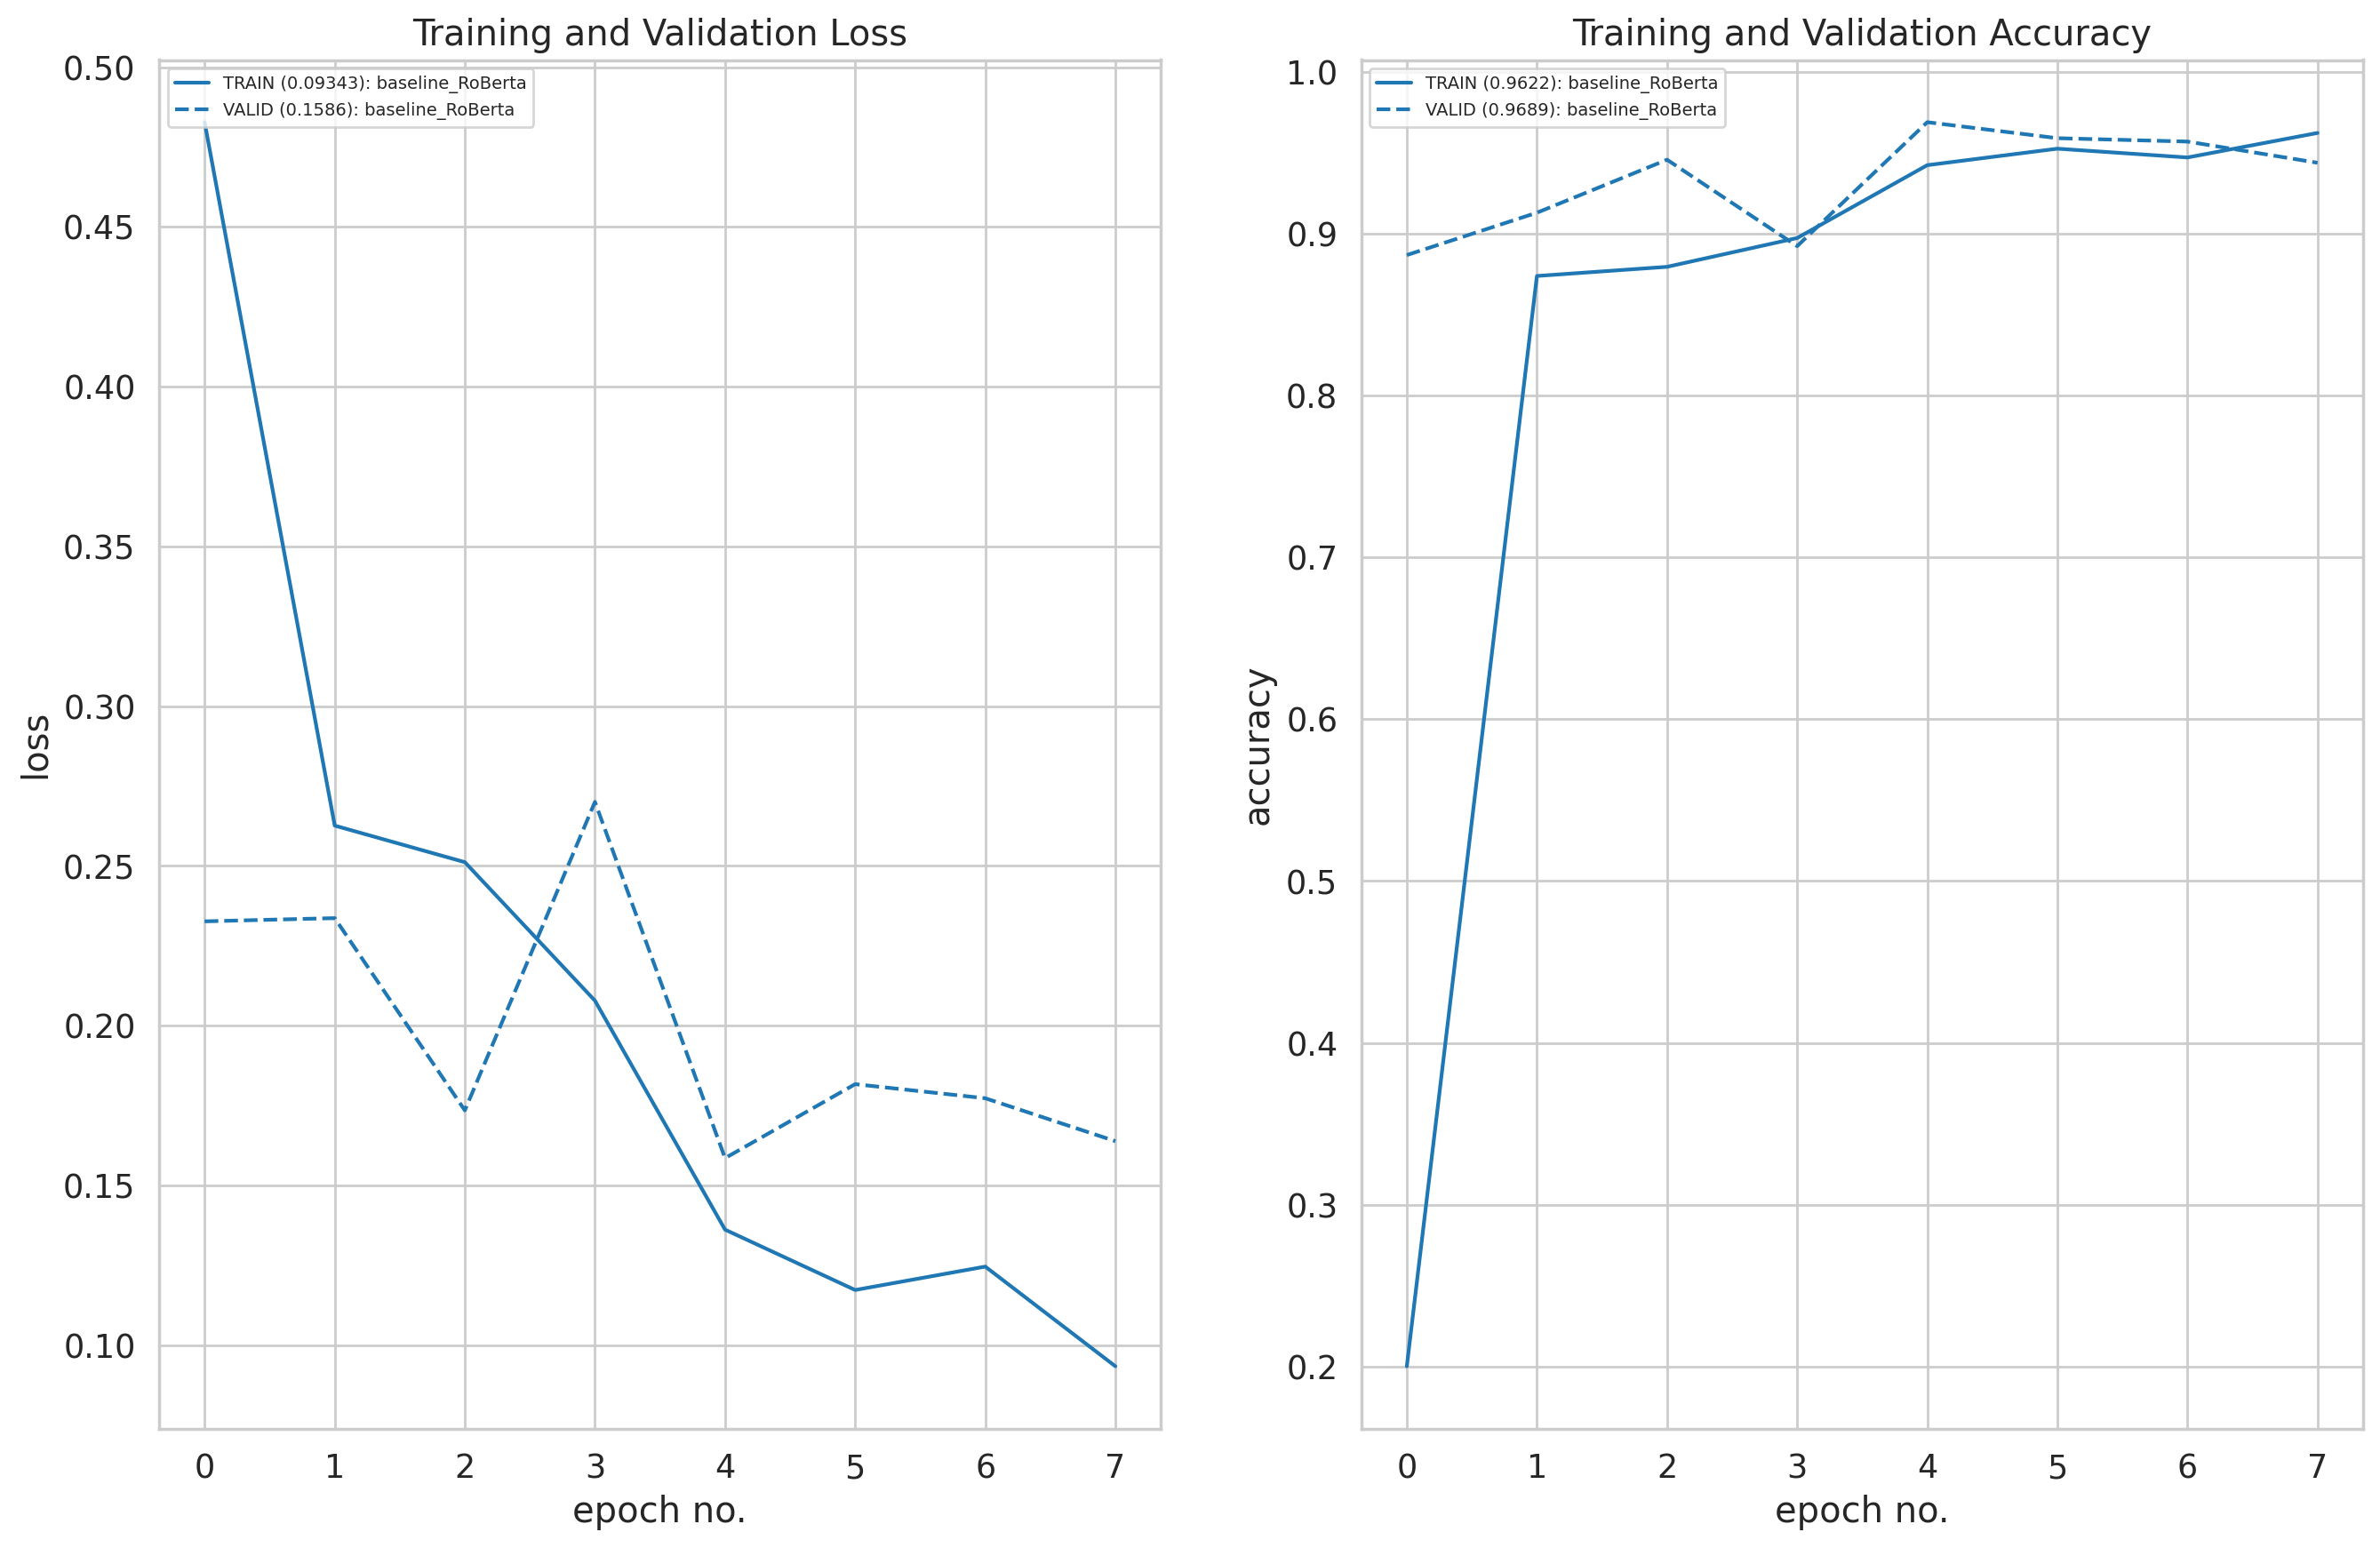

In [65]:
plot_loss_accuracy(train_loss= [train_losses],
                   val_loss= [test_losses],
                   train_acc= [train_metrics],
                   val_acc= [test_metrics],
                   labels=['baseline_RoBerta'],
                   colors=['blue'],
                   loss_legend_loc='upper left',
                   acc_legend_loc='upper left',
                   legend_font=7)

### Evalutaion Framework

In [66]:
def get_predictions(model, data_loader):

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  model.eval()
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      ).flatten()

      probs = torch.sigmoid(outputs)
      preds = torch.round(probs)


      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()

  return review_texts, predictions, prediction_probs

In [67]:
raw_sentences = ["What was the sales for brand Hurricane in India?",
                 "How did the sales for brand Hurricane changed over last one year?",
                 "Explain how has the impact on water shortage on the production of beer in India?",
                 "How is the performance of Classic lager segment in LP TY compared to LP YA?",
                 "Detail the reasons for drop in sales for brand Corona in the west?",
                 "How did the sales evolved for brand Jupiter over the period of last 6 months?",
                 "Explain in details the reasons for the abrupt changes in sales pattern of Becks in Asian markets?"]

In [68]:
eval_dataset = QuestionClassficationDataset(
  question=raw_sentences,
  targets=None,
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [69]:
eval_dataloader = DataLoader(
  eval_dataset,
  batch_size=1,
  shuffle=False
)

In [70]:
review_texts, predictions, prediction_probs = get_predictions(robert_base_classifier , eval_dataloader)

In [71]:
predictions

tensor([0., 1., 1., 1., 1., 1., 1.])

In [72]:
prediction_probs

tensor([0.0043, 0.7105, 0.9989, 0.9989, 0.9990, 0.5545, 0.9990])

We can use all the next applicable steps used in case of Bert Series-2 her in Roberta